In [1]:
from QuantLib import *
import numpy as np
import math
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Barrier Option: Up-and-Out Call 
# Strike 100, Barrier 150, Rebate 50, Exercise date 4 years 
#Set up the global evaluation date to today

def Option_Pricing(Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity):

    #Example:
    #Option_Type = Option.Put
    #Barrier_Type = Barrier.UpOut
    #Spot_Price = 24363.0
    #Strike_Price = 24990.0
    #Barrier_Price = 24890.0
    #Volatility = 0.80
    #Risk_Free_Rate = 0.019
    #Dividend_Rate = 0.0414
    #Rebate = 100.0
    #today = Date(18,June,2020)  # or today = Date().todaysDate()
    #Maturity = Date(30, December, 2020)
    
    Option_Type = Option_Type
    Barrier_Type = Barrier_Type
    Spot_Price = Spot_Price
    Strike_Price = Strike_Price
    Barrier_Price = Barrier_Price
    Volatility = Volatility
    Risk_Free_Rate = Risk_Free_Rate
    Dividend_Rate = Dividend_Rate
    Rebate = Rebate
    today = today  # or today = Date().todaysDate()
    Maturity = Maturity
    
    
    Settings.instance().evaluationDate = today

    # Specify option
    option = BarrierOption(Barrier_Type, Barrier_Price, Rebate, PlainVanillaPayoff(Option_Type, Strike_Price), EuropeanExercise(Maturity))

    #initialValue, riskFreeTS, dividendTS and volatility
    initialValue = QuoteHandle(SimpleQuote(Spot_Price))
    riskFreeTS = YieldTermStructureHandle(FlatForward(today, Risk_Free_Rate, Actual365Fixed()))
    dividendTS = YieldTermStructureHandle(FlatForward(today, Dividend_Rate, Actual365Fixed()))
    volTS = BlackVolTermStructureHandle(BlackConstantVol(today, NullCalendar(), Volatility, Actual365Fixed()))
    process = BlackScholesMertonProcess(initialValue, dividendTS, riskFreeTS, volTS)

    
    # Build the engine (based on an analytic formula) and set it to the option for evaluation
    option.setPricingEngine(AnalyticBarrierEngine(process))

    
    # Market Data Changes
    # Change the market data to get new option pricing. 

    # Set initial value and define h
    h=0.00000001
    
    
    # Bump up the price by h
    P_plus = BarrierOption(Barrier_Type, Barrier_Price, Rebate, PlainVanillaPayoff(Option_Type, Strike_Price), EuropeanExercise(Maturity))

    initialValue_plus = QuoteHandle(SimpleQuote(Spot_Price+h))
    process = BlackScholesMertonProcess(initialValue_plus, dividendTS, riskFreeTS, volTS)
    P_plus.setPricingEngine(AnalyticBarrierEngine(process))
  

    # Bump down the price by h
    P_minus = BarrierOption(Barrier_Type, Barrier_Price, Rebate, PlainVanillaPayoff(Option_Type, Strike_Price), EuropeanExercise(Maturity))
    
    initialValue_minus = QuoteHandle(SimpleQuote(Spot_Price-h))
    process = BlackScholesMertonProcess(initialValue_minus, dividendTS, riskFreeTS, volTS)
    P_minus.setPricingEngine(AnalyticBarrierEngine(process))


    # Calculate Greeks: Delta, Gamma, Vega, Theta, Rho
    delta = (P_plus.NPV() - P_minus.NPV())/(2*h)
    
    
    
    
    
    
    return option.NPV(), delta

    
    

In [3]:
def Spot_Spot_slide(Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity, Adj_Option_Price, Step_Size=10, Min=10, Max=10, Round=3): 
        

  
        S0 = np.linspace(Spot_Price - Step_Size*Min,Spot_Price + Step_Size*Max, Min + Max + 1)
        
        price = np.array([])
        for S in S0:
            price = np.append(price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])

        plt.figure(figsize=(14, 7))
        plt.plot(S0, price, label = "Black_Scholes Pricing")
        plt.title("Option Price & Spot Price")
        plt.xlabel("Spot price (S0)")
        plt.ylabel("Option_Price")
        plt.legend()

        
        Offset = Adj_Option_Price - Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0]
        
        pd.options.display.max_rows, pd.options.display.max_columns = 1000, 50
        data = {'Spot_Price': S0, 'Option_Price': np.around(price/10000,Round), 'Offset': np.around(Offset/10000,Round), 'Adj_Option_Price': np.around((price + Offset)/10000,Round)}
        df = pd.DataFrame(data=data)
        
        plt.figure(figsize=(14, 7))
        plt.plot(S0, price + Offset, label = "Black_Scholes Pricing")
        plt.title("Adjusted Option Price & Spot Price")
        plt.xlabel("Spot price (S0)")
        plt.ylabel("Adj_Option_Price")
        plt.legend()
        
        
        
        
        return df

In [4]:
def Spot_Option_Slide(Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity, Adj_Option_Price, Min=10, Max=10, Round=3): 
        
        
        S0 = np.linspace(Spot_Price - 10/delta * Min,Spot_Price +  10/delta * Max, Min + Max + 1)
        
        price = np.array([])
        for S in S0:
            price = np.append(price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])

        plt.figure(figsize=(14, 7))
        plt.plot(S0, price, label = "Black_Scholes Pricing")
        plt.title("Option Price & Spot Price")
        plt.xlabel("Spot price (S0)")
        plt.ylabel("Option_Price")
        plt.legend()

        
        Offset = Adj_Option_Price - Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0]
        
        pd.options.display.max_rows, pd.options.display.max_columns = 1000, 50
        data = {'Spot_Price': S0, 'Option_Price': price/10000, 'Offset': Offset/10000, 'Adj_Option_Price': (price + Offset)/10000}
        df = pd.DataFrame(data=data)
        
        plt.figure(figsize=(14, 7))
        plt.plot(S0, price + Offset, label = "Black_Scholes Pricing")
        plt.title("Adjusted Option Price & Spot Price")
        plt.xlabel("Spot price (S0)")
        plt.ylabel("Adj_Option_Price")
        plt.legend()
        
        
        
        
        return df

In [177]:
def Spot_Adj_Option_Slide(Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity, Adj_Option_Price, Min=10, Max=10, S0_Round=0, Option_Round=3, Precision=10): 
        

        Offset = Adj_Option_Price - Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0]
        
            
        
        Adj_Dividend_Rate = Dividend_Search(Adj_Option_Price, Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity)
        
        
        # Adj_Spot_Price = Spot_Price + 1/delta * Offset
        
        
        adj_delta = Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Adj_Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[1]
      
        S0 = np.linspace(Spot_Price - Precision/adj_delta * Min, Spot_Price +  Precision/adj_delta * Max, Min + Max + 1)
        
        
        Adj_price = np.array([])
        for S in S0:
            Adj_price = np.append(Adj_price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Adj_Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])

        price = np.array([])
        for S in S0:
            price = np.append(price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])


        pd.options.display.max_rows, pd.options.display.max_columns = 1000, 50
        data = {'Spot_Price': np.around(S0,0),  'Adj_Option_Price': np.around(Adj_price/10000,4), 'Option_Price':  np.around(price/10000,4), 'Offset': Adj_price/10000 - price/10000}
        df = pd.DataFrame(data=data)

        
        return df

In [173]:
def Spot_Adj_Option_Slide_Auto(Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity, Adj_Option_Price, Min=10, Max=10, S0_Round=0, Option_Round=3): 
        

        Offset = Adj_Option_Price - Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0]
        
            
        
        Adj_Dividend_Rate = Dividend_Search(Adj_Option_Price, Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity)
        
        
        # Adj_Spot_Price = Spot_Price + 1/delta * Offset
        
        
        adj_delta = Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Adj_Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[1]
      
        S0 = np.linspace(Spot_Price - 1/adj_delta * Min, Spot_Price +  1/adj_delta * Max, Min + Max + 1)
        
        
        Adj_price = np.array([])
        for S in S0:
            Adj_price = np.append(Adj_price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Adj_Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])

        price = np.array([])
        for S in S0:
            price = np.append(price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])


        pd.options.display.max_rows, pd.options.display.max_columns = 1000, 50
        data = {'Spot_Price': np.around(S0,0),  'Adj_Option_Price': np.around(Adj_price/10000,3), 'Option_Price': price/10000, 'Offset': Adj_price/10000 - price/10000}
        df = pd.DataFrame(data=data)
        
        
        count = 0
        differ = 0
        
        while differ == 0:
            count += 1
            differ = df.loc[df.index[Min-count],'Adj_Option_Price'] - df.loc[df.index[Min],'Adj_Option_Price']
            
        
        True_Option_Price = df.loc[df.index[Min-count],'Adj_Option_Price']
        True_Spot_Price = df.loc[df.index[Min-count],'Spot_Price']
        
        
        Offset = True_Option_Price - Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = True_Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0]
        
            
        print(True_Option_Price, True_Spot_Price)
            
        
        Adj_Dividend_Rate = Dividend_Search(True_Option_Price*10000, Option_Type, Barrier_Type, True_Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity)
        
        
        # Adj_Spot_Price = Spot_Price + 1/delta * Offset
        
        
        adj_delta = Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = True_Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Adj_Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[1]
      
        S0 = np.linspace(True_Spot_Price - 10/adj_delta * Min, True_Spot_Price +  10/adj_delta * Max, Min + Max + 1)
        
        
        Adj_price = np.array([])
        for S in S0:
            Adj_price = np.append(Adj_price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Adj_Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])

        price = np.array([])
        for S in S0:
            price = np.append(price, Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = S, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = Dividend_Rate, Rebate = Rebate, today = today, Maturity = Maturity)[0])

        

        data = {'Spot_Price': np.around(S0,S0_Round), 'Adj_Option_Price': np.around(Adj_price/10000,Option_Round), 'Option_Price': np.around(price/10000,Option_Round), 'Offset': Adj_price/10000 - price/10000}
        df = pd.DataFrame(data=data)
        
        
        plt.figure(figsize=(14, 7))
        plt.plot(S0, price, label = "Black_Scholes Pricing")
        plt.title("Option Price & Spot Price")
        plt.xlabel("Spot price (S0)")
        plt.ylabel("Option_Price")
        plt.legend()
        
        
        plt.figure(figsize=(14, 7))
        plt.plot(S0, Adj_price, label = "Black_Scholes Pricing")
        plt.title("Adjusted Option Price & Spot Price")
        plt.xlabel("Spot price (S0)")
        plt.ylabel("Adj_Option_Price")
        plt.legend()
        
        
        
        return df

In [151]:
def Dividend_Search(option_price, Option_Type, Barrier_Type, Spot_Price, Strike_Price, Barrier_Price, Volatility, Risk_Free_Rate, Dividend_Rate, Rebate, today, Maturity):
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 0.00001
    upper_spot = 1.0
    lower_spot = 0.0
    iteration = 0
    

    while 1:
        iteration +=1
        mid_spot = (upper_spot + lower_spot)/2.0
        price = Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = mid_spot, Rebate = Rebate, today = today, Maturity = Maturity)[0]
        
        if Option_Type == Option.Put:
            lower_price = Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = lower_spot, Rebate = Rebate, today = today, Maturity = Maturity)[0]
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_spot = mid_spot
            else:
                upper_spot = mid_spot
            if abs(price - option_price) < precision: break 
            if iteration > 10000: raise ValueError("Computational error occured. ")

        elif Option_Type == Option.Call:
            upper_price = Option_Pricing(Option_Type = Option_Type, Barrier_Type = Barrier_Type, Spot_Price = Spot_Price, Strike_Price = Strike_Price, Barrier_Price = Barrier_Price, Volatility = Volatility, Risk_Free_Rate = Risk_Free_Rate, Dividend_Rate = upper_spot, Rebate = Rebate, today = today, Maturity = Maturity)[0]
            if (upper_price - option_price) * (price - option_price) > 0:
                upper_spot = mid_spot
            else:
                lower_spot = mid_spot
            if abs(price - option_price) < precision: break 
            if iteration > 10000: raise ValueError("Computational error occured. ")
                
        else:
            raise NameError('delta = 0 !!!!')

    return mid_spot

0.0659 24503.696952096714


,Spot_Price,Adj_Option_Price,Option_Price,Offset
0,24573.0,0.056,0.051,0.004489
1,24566.0,0.057,0.052,0.004585
2,24559.0,0.058,0.053,0.004681
3,24552.0,0.059,0.054,0.004778
4,24546.0,0.060,0.055,0.004874
5,24539.0,0.061,0.056,0.004969
6,24532.0,0.062,0.057,0.005065
7,24525.0,0.063,0.058,0.005161
8,24518.0,0.064,0.059,0.005256
9,24511.0,0.065,0.060,0.005352


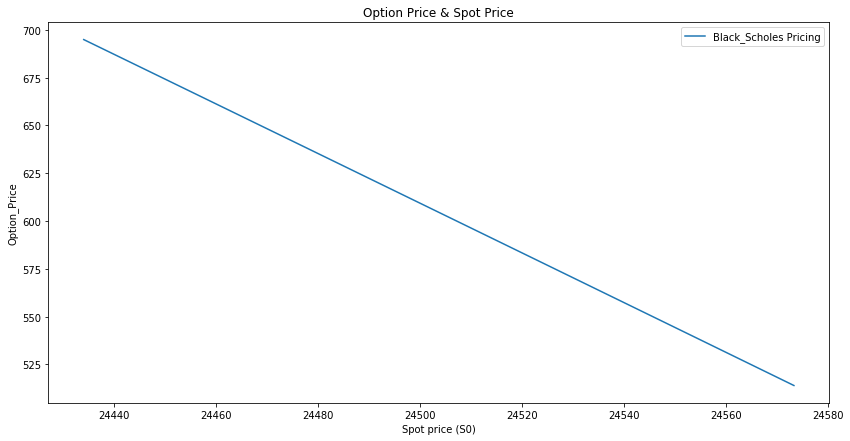

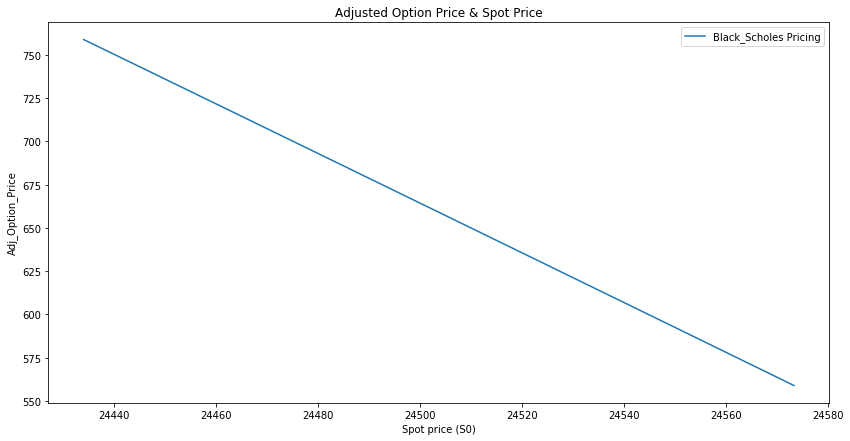

In [152]:
Spot_Adj_Option_Slide_Auto(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24503.0, Strike_Price = 24990.0, Barrier_Price = 24890.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(18,June,2020), Maturity = Date(30, December, 2020), Adj_Option_Price = 660, Min = 10, Max = 10)

In [153]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24350.0, Strike_Price = 24990.0, Barrier_Price = 24890.0 , Volatility = 0.80, Risk_Free_Rate = 0.019, Dividend_Rate = 0.0414, Rebate = 100.0, today = Date(18,June,2020), Maturity = Date(30, December, 2020))[1]

-1.01542809716193

In [154]:
Dividend_Search(option_price = 800, Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24363.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))

0.3172212541103363

In [155]:
d = Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24363.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[1]
d

-1.2914654234918999

In [156]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24363.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[0]

773.0259945254356

In [157]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24363.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.3172212541103363, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[0]

799.9999971819666

In [158]:
Dividend_Search(option_price = 600, Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24553.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))

0.43114587664604187

In [159]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24553.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.43114587664604187, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[0]

599.9999971471614

In [160]:
d = Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24553.0, Strike_Price = 24990.0, Barrier_Price = 24880.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.43114587664604187, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[1]
d

-1.5167643141467124

In [161]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24430.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[0]

815.1116565656555

In [162]:
d = Dividend_Search(option_price = 850, Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24430.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))
d

0.3252650499343872

In [163]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24430.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = d, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[0]

849.9999952086728

In [164]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24430.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = d, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))[1]

-1.349718559140456

0.0849 24433.736941175375


,Spot_Price,Adj_Option_Price,Option_Price,Offset
0,24507.0,0.075,0.072,0.003367
1,24500.0,0.076,0.072,0.003418
2,24493.0,0.077,0.073,0.003469
3,24485.0,0.078,0.074,0.003519
4,24478.0,0.079,0.075,0.003569
5,24471.0,0.080,0.076,0.003620
6,24463.0,0.081,0.077,0.003670
7,24456.0,0.082,0.078,0.003720
8,24448.0,0.083,0.079,0.003770
9,24441.0,0.084,0.080,0.003821


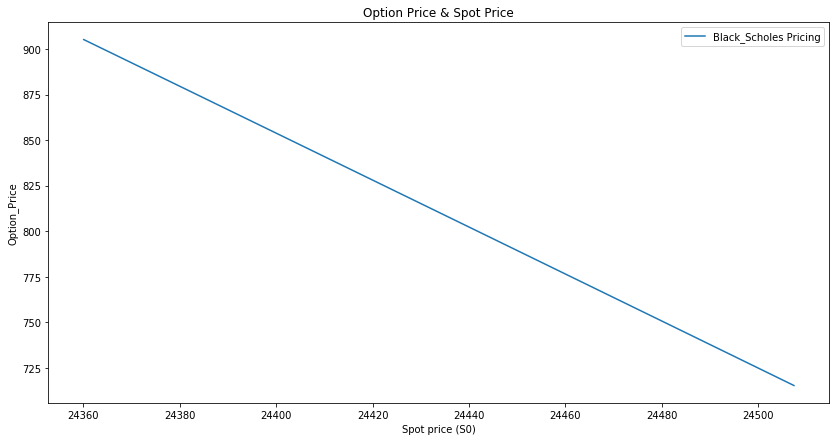

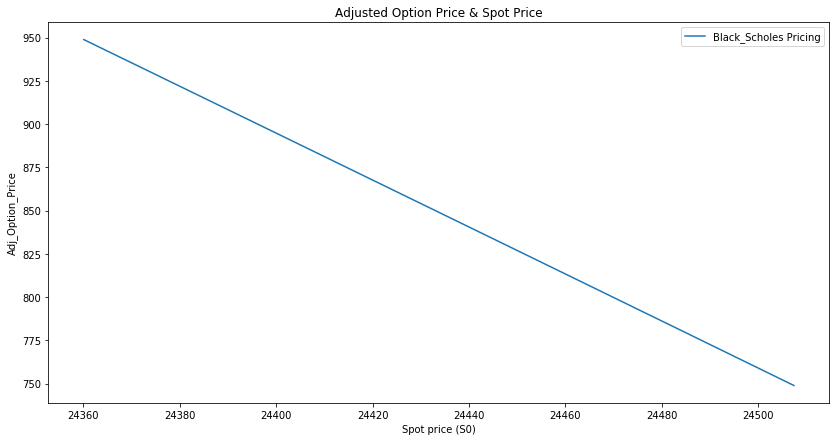

In [165]:
Spot_Adj_Option_Slide_Auto(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24433.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020), Adj_Option_Price = 850, Min = 10, Max = 10)

In [166]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24433.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = d, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))

(845.9503610084604, -1.3498151929525193)

In [167]:
Option_Pricing(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24488.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = d, Rebate = 100.0, today = Date(22,June,2020), Maturity = Date(30, December, 2020))

(771.6272419975169, -1.3527028386306483)

0.1029 24275.76672445998


,Spot_Price,Adj_Option_Price,Option_Price,Offset
0,24352.0,0.093,0.091,0.001435
1,24345.0,0.094,0.092,0.001451
2,24337.0,0.095,0.093,0.001468
3,24329.0,0.096,0.094,0.001485
4,24322.0,0.097,0.095,0.001501
5,24314.0,0.098,0.096,0.001518
6,24306.0,0.099,0.097,0.001534
7,24299.0,0.100,0.098,0.001551
8,24291.0,0.101,0.099,0.001568
9,24283.0,0.102,0.100,0.001584


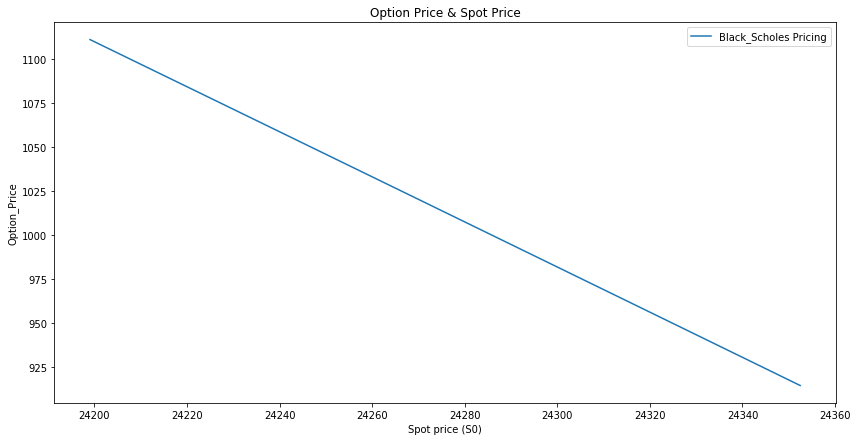

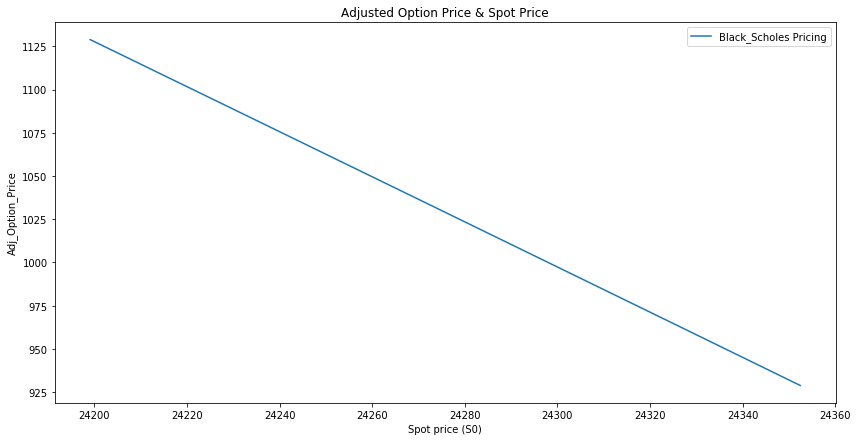

In [168]:
Spot_Adj_Option_Slide_Auto(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24275.0, Strike_Price = 25080.0, Barrier_Price = 24980.0 , Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(23,June,2020), Maturity = Date(30, December, 2020), Adj_Option_Price = 1030, Min = 10, Max = 10,S0_Round=0, Option_Round=3)

In [169]:
np.around(0.1155,3)

0.116

# Put

In [179]:
Spot_Adj_Option_Slide(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24870.0, Strike_Price = 25600.0, Barrier_Price = 25500.0, Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(24,June,2020), Maturity = Date(27, April, 2023), Adj_Option_Price = 960, Min = 10, Max = 10,S0_Round=0, Option_Round=3)

,Spot_Price,Adj_Option_Price,Option_Price,Offset
0,24944.0,0.086,0.0922,-0.006205
1,24936.0,0.087,0.0933,-0.006285
2,24929.0,0.088,0.0944,-0.006365
3,24922.0,0.089,0.0954,-0.006445
4,24914.0,0.090,0.0965,-0.006525
5,24907.0,0.091,0.0976,-0.006605
6,24900.0,0.092,0.0987,-0.006685
7,24892.0,0.093,0.0998,-0.006764
8,24885.0,0.094,0.1008,-0.006844
9,24877.0,0.095,0.1019,-0.006923


0.088 24936.0


,Spot_Price,Adj_Option_Price,Option_Price,Offset
0,25009.0,0.078,0.083,-0.004672
1,25002.0,0.079,0.084,-0.004739
2,24994.0,0.080,0.085,-0.004807
3,24987.0,0.081,0.086,-0.004874
4,24980.0,0.082,0.087,-0.004942
5,24972.0,0.083,0.088,-0.005009
6,24965.0,0.084,0.089,-0.005076
7,24958.0,0.085,0.090,-0.005143
8,24951.0,0.086,0.091,-0.005211
9,24943.0,0.087,0.092,-0.005278


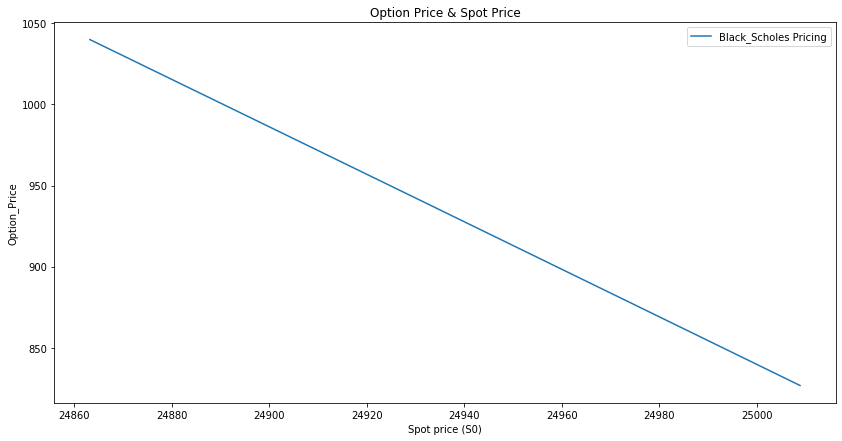

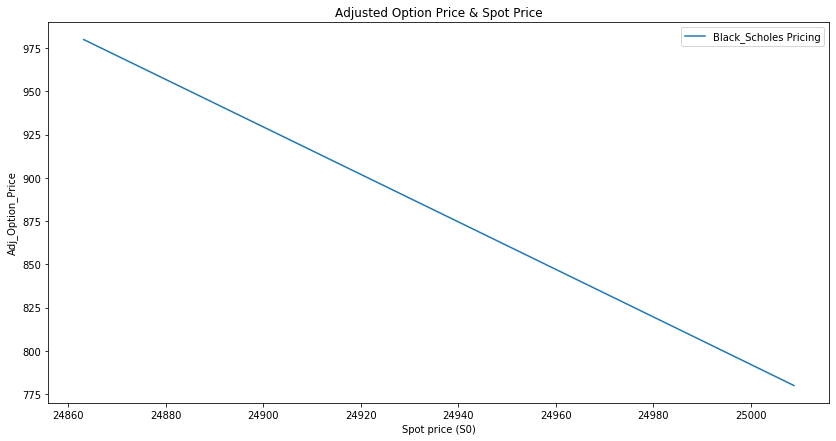

In [176]:
Spot_Adj_Option_Slide_Auto(Option_Type = Option.Put, Barrier_Type = Barrier.UpOut, Spot_Price = 24932.0, Strike_Price = 25600.0, Barrier_Price = 25500.0, Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(24,June,2020), Maturity = Date(27, April, 2023), Adj_Option_Price = 890, Min = 10, Max = 10,S0_Round=0, Option_Round=3)

# Call

0.0669 24885.724769592223


,Spot_Price,Adj_Option_Price,Option_Price,Offset
0,24758.0,0.057,0.025,0.032208
1,24771.0,0.058,0.025,0.032892
2,24784.0,0.059,0.025,0.033576
3,24796.0,0.060,0.026,0.034259
4,24809.0,0.061,0.026,0.034943
5,24822.0,0.062,0.026,0.035626
6,24835.0,0.063,0.027,0.036310
7,24847.0,0.064,0.027,0.036993
8,24860.0,0.065,0.027,0.037676
9,24873.0,0.066,0.028,0.038360


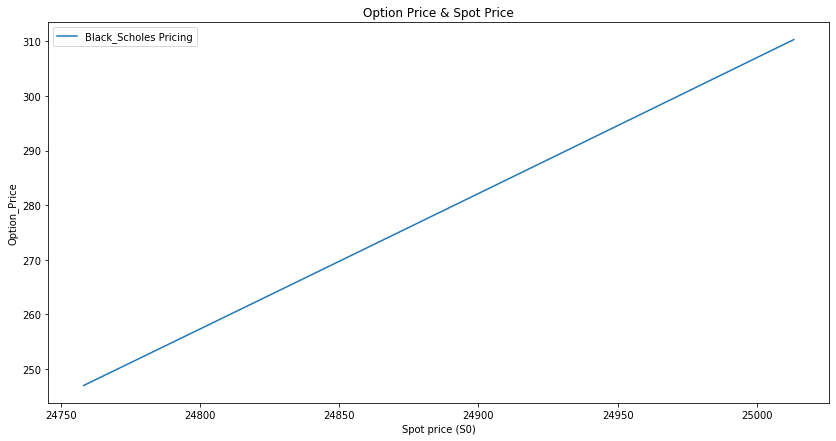

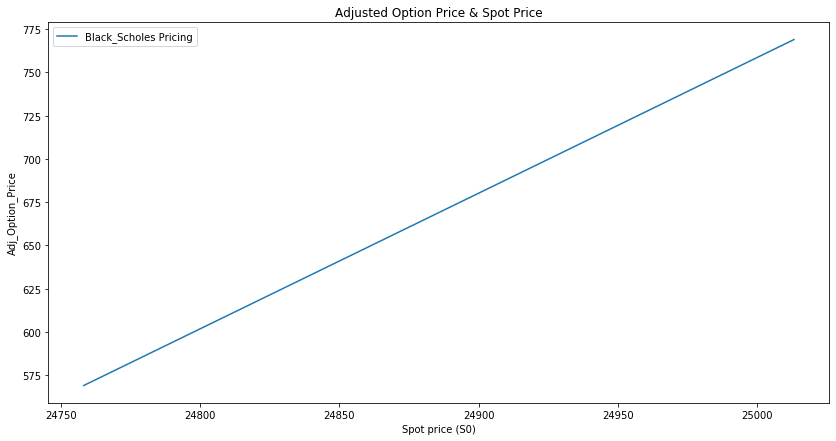

In [172]:
Spot_Adj_Option_Slide_Auto(Option_Type = Option.Call, Barrier_Type = Barrier.DownOut, Spot_Price = 24887.0, Strike_Price = 24050.0, Barrier_Price = 24159.0, Volatility = 0.80, Risk_Free_Rate = 0.03, Dividend_Rate = 0.28, Rebate = 100.0, today = Date(24,June,2020), Maturity = Date(27, April, 2023), Adj_Option_Price = 670, Min = 10, Max = 10,S0_Round=0, Option_Round=3)